In [1]:
# Import Dependencies and modules
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from string import punctuation
from collections import Counter
from io import StringIO
from nltk.corpus import stopwords
import nltk
import glob
import errno
import os
import json
import pickle
import en_core_web_md
from spacy import displacy
import gensim
from itertools import chain
from gensim import models, corpora, similarities
from gensim.models import CoherenceModel, TfidfModel
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from spacy.lang.en import English
import math

# Load Data

In [2]:
# Load each json file
with open('iphonex_digtrends.json') as f:
    iphonex_digtrends = json.load(f)

with open('iphonex_gizmodo.json') as f:
    iphonex_gizmodo = json.load(f)

with open('iphonex_techradar.json') as f:
    iphonex_techradar = json.load(f)

with open('S9_digtrends.json') as f:
    S9_digtrends = json.load(f)

with open('S9_gizmodo.json') as f:
    S9_gizmodo = json.load(f)

with open('S9_techradar.json') as f:
    S9_techradar = json.load(f)

# Clean Data

In [3]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!

    text = str(text).replace("\n", "")
    text = str(text).replace("\t", "")
    text = str(text).replace("\\n", "")
    text = str(text).replace("\\t", "")
    text = str(text).replace("\\", "")
    text = str(text).replace("xa0", " ")
    text = str(text).replace("\'", "")
    text = re.sub("<p>", "", str(text))
    text = re.sub("</p>", "", str(text))
    text = re.sub("</a>", "", str(text))
    text = re.sub('<[^>]+>', "", str(text))
    text = str(text).replace("\\u2019", "")
    text = str(text).replace("\\u2013", "")
    text = str(text).replace("\\u2018", "")
    text = str(text).replace("\\u00a0", "")
    text = str(text).replace("\\u00a3", "")
    text = str(text).replace("\u2014", "")
    text = str(text).replace("\u201d", "")
    text = str(text).replace("\u201c", "")
    return text


In [4]:
# Populate each JSON file into a data frame

iphonex_digtrends = pd.DataFrame.from_dict(iphonex_digtrends, orient='columns')
iphonex_gizmodo = pd.DataFrame.from_dict(iphonex_gizmodo, orient='columns')
iphonex_techradar = pd.DataFrame.from_dict(iphonex_techradar, orient='columns')
S9_digtrends = pd.DataFrame.from_dict(S9_digtrends, orient='columns')
S9_gizmodo = pd.DataFrame.from_dict(S9_gizmodo, orient='columns')
S9_techradar = pd.DataFrame.from_dict(S9_techradar, orient='columns')

In [5]:
# Define function to clean text
def clean_text(df):
    # Convert lists to strings and remove brackets
    df['text'] = df['text'].astype(str)
    df['author'] = df['author'].astype(str)

    df['text'] = df['text'].map(lambda x: x.strip('[]'))
    df['author'] = df['author'].map(lambda x: x.strip('[]'))

    # Clean text
    df['text'] = df['text'].apply(lambda x: text_cleaner(x))
    df['title'] = df['title'].apply(lambda x: text_cleaner(x))
    df['author'] = df['author'].apply(lambda x: text_cleaner(x))

    
# Put dataframes into a list to iterate through
dataframes = [iphonex_digtrends, iphonex_gizmodo, iphonex_techradar, S9_digtrends, S9_gizmodo, S9_techradar]

# Clean each Data Frame
for dataframe in dataframes:
    clean_text(dataframe)

In [6]:
# Label all the rows in the dataframe with the type of phone discussed in text

iphones = [iphonex_digtrends, iphonex_gizmodo, iphonex_techradar]
s9s = [S9_digtrends, S9_gizmodo, S9_techradar]

for dataframe in iphones:
    dataframe['phone'] = 'IPhone X'
    
for dataframe in s9s:
    dataframe['phone'] = 'Samsung Galaxy S9'


In [7]:
# Concat all the dataframes into one dataframe
all_frames = [iphonex_digtrends, iphonex_gizmodo, iphonex_techradar, S9_digtrends, S9_gizmodo, S9_techradar]
df = pd.concat(all_frames)


In [8]:
# Visualize dataframe
df.head()

,author,text,title,phone
0,Eric Brackett,The iPhone X launched to stellar reviews and e...,Shrinking demand forces Apple to slow down iPh...,IPhone X
1,Lucas Coll,"When it comes to high-quality devices, like th...",Looking to upgrade? These are the best iPhone ...,IPhone X
2,Simon Hill,The iPhone X is completely different from any ...,"The most common iPhone X problems, and how to ...",IPhone X
3,Trevor Mogg,"If you’re in the market for an iPhone X, and p...","This $4,600 solar charger comes with an iPhone...",IPhone X
4,Mark Jansen,", The initial estimates, set during the Novemb...",Apple will halve iPhone X production after lim...,IPhone X


# Load all Pre-Trained Models

In [9]:
# Load Opinion Lexicon
negatives = open('negative-words.txt', encoding = 'latin-1')
positives = open('positive-words.txt', encoding = 'latin-1')

# Read file
neg_unedit = [line.strip() for line in negatives.readlines()]
pos_unedit = [line.strip() for line in positives.readlines()]

# Extract only the list of words in the lexicon
neg = neg_unedit[31:]
pos = pos_unedit[30:]

# Compile opinion words
opinion_words = neg + pos

In [10]:
# Load Google's pre-trained Word2Vec model.
word2vec = gensim.models.KeyedVectors.load_word2vec_format('/Users/ayankarim/Desktop/GoogleNews-vectors-negative/GoogleNews-vectors-negative300.bin', binary=True) 

# load the Topic Model from previous notebook
lda = pickle.load(open("lda_model.pkl", 'rb'))

# load the Multi-label binarizer from previous notebook
mlb = pickle.load(open("mlb.pkl", 'rb'))

# load the fitted naive bayes model from previous notebook
svm_model = pickle.load(open("svm_model.pkl", 'rb'))


# Pre-Process Data for NLP

In [11]:
# Convert documents to sentences
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))
        
data = list(df['text'])
data_words = list(sent_to_words(data))

In [12]:
# Create Bigrams and Trigrams

# Build the models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# fast way to get a sentece clubbed as a bigram/trigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [13]:
# Remove Stopwords, make bigrams and lemmatize
stop_words = stopwords.words('english')
stop_words.extend(['pixel', 'iphone', 'samsung', 'apple', 'essential', 'xs', 'max', 
                  'huawei', 'galaxy', 'note', 'moto', 'oneplus', 'android', 'mate', 'pro', 'lg', 'sony', 'razer', 'phone', 'company', 
                  'smartphone', 'google', 'thinq', 'nokia', 'htc', 'xperia', 'xz'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['launch', 'stellar', 'review', 'equally', 'strong', 'sale', 'fast', 'report', 'demand', 'slow', 'considerably', 'source', 'supply', 'chain', 'say', 'plan', 'make', 'mere', 'million_unit', 'second', 'quarter', 'year', 'part', 'problem', 'stem', 'simple', 'fact', 'rush', 'holiday', 'sale', 'convince', 'produce', 'many', 'unit', 'need', 'burn', 'supply', 'total', 'sell', 'iphone', 'holiday', 'season', 'tim', 'cook', 'say', 'outsell', 'model', 'week', 'first', 'quarter', 'release', 'track', 'avalon', 'analyst', 'neil', 'cybart', 'estimate', 'account', 'percent', 'sale', 'holiday', 'season', 'demand', 'device', 'slow', 'considerably', 'however', 'supply', 'chain', 'reflect', 'new', 'reality', 'tsmc', 'produce', 'many', 'chip', 'use', 'warn', 'investor', 'fall', 'demand', 'chip', 'analyst', 'expect', 'tsmc', 'earn', 'quarterly', 'guidance', 'report', 'say', 'number', 'close', 'australia', 'base', 'make', 'component', 'use', 'facial_recognition', 'system', 'warn', 'expect', 'second', 'quart

# Topic Modeling

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [16]:
# gather tfidf scores
tfidf = models.TfidfModel(corpus, id2word = id2word)

# filter low value words
low_value = 0.025

for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    new_bow = [b for b in bow if b[0] not in low_value_words]

    #reassign        
    corpus[i] = new_bow

In [17]:
# Assigns the topics to the documents in corpus
lda_corpus = lda[corpus]

# Find the threshold, let's set the threshold to be 1/#clusters,
# To prove that the threshold is sane, we average the sum of all probabilities:
scores = list(chain(*[[score for topic_id,score in topic] \
                      for topic in [doc for doc in lda_corpus]]))
threshold = sum(scores)/len(scores)
print (threshold)

reliability = [j for i,j in zip(lda_corpus,data) if i[0][1] > threshold]
functionality = [j for i,j in zip(lda_corpus,data) if i[1][1] > threshold]
design = [j for i,j in zip(lda_corpus,data) if i[2][1] > threshold]

0.33333333390053466


In [18]:
labelled_df = df

# Assign labels
labelled_df['reliability'] = ""
labelled_df['functionality'] = ""
labelled_df['design'] = ""

labelled_df['reliability'] = np.where(labelled_df['text'].isin(reliability), 'reliability', None)
labelled_df['functionality'] = np.where(labelled_df['text'].isin(functionality), 'functionality', None)
labelled_df['design'] = np.where(labelled_df['text'].isin(design), 'design', None)

labelled_df['labelled'] = labelled_df[['reliability', 'functionality', 'design']].values.tolist()
labelled_df['labelled'] = labelled_df['labelled'].apply(lambda x: list(filter(lambda a: a != None, x)))
labelled_df = labelled_df.drop(['reliability', 'functionality', 'design'], axis=1)

In [19]:
labelled_df.head()

,author,text,title,phone,labelled
0,Eric Brackett,The iPhone X launched to stellar reviews and e...,Shrinking demand forces Apple to slow down iPh...,IPhone X,"[reliability, design]"
1,Lucas Coll,"When it comes to high-quality devices, like th...",Looking to upgrade? These are the best iPhone ...,IPhone X,"[reliability, functionality]"
2,Simon Hill,The iPhone X is completely different from any ...,"The most common iPhone X problems, and how to ...",IPhone X,[reliability]
3,Trevor Mogg,"If you’re in the market for an iPhone X, and p...","This $4,600 solar charger comes with an iPhone...",IPhone X,[reliability]
4,Mark Jansen,", The initial estimates, set during the Novemb...",Apple will halve iPhone X production after lim...,IPhone X,[reliability]


In [20]:
# Load Neural Coreference to replace parse text and replace pronouns
nlp = en_core_web_md.load()

# Aspect-Based Sentiment Extraction

In [21]:
# Define feature_sentiment function
def feature_sentiment(sentence):
    '''
    input: dictionary and sentence
    function: appends dictionary with new features if the feature did not exist previously,
              then updates sentiment to each of the new or existing features
    output: updated dictionary
    '''
    
    sent_dict = Counter()
    sentence = nlp(sentence)
    debug = 0
    for token in sentence:
    #    print(token.text,token.dep_, token.head, token.head.dep_)
        # check if the word is an opinion word, then assign sentiment
        if token.text in opinion_words:
            sentiment = 1 if token.text in pos else -1
            # if target is an adverb modifier (i.e. pretty, highly, etc.)
            # but happens to be an opinion word, ignore and pass
            if (token.dep_ == "advmod"):
                continue
            elif (token.dep_ == "amod"):
                sent_dict[token.head.text] += sentiment
            # for opinion words that are adjectives, adverbs, verbs...
            else:
                for child in token.children:
                    # if there's a adj modifier (i.e. very, pretty, etc.) add more weight to sentiment
                    # This could be better updated for modifiers that either positively or negatively emphasize
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")) and (child.text in opinion_words):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if child.dep_ == "neg":
                        sentiment *= -1
                for child in token.children:
                    # if verb, check if there's a direct object
                    if (token.pos_ == "VERB") & (child.dep_ == "dobj"):                        
                        sent_dict[child.text] += sentiment
                        # check for conjugates (a AND b), then add both to dictionary
                        subchildren = []
                        conj = 0
                        for subchild in child.children:
                            if subchild.text == "and":
                                conj=1
                            if (conj == 1) and (subchild.text != "and"):
                                subchildren.append(subchild.text)
                                conj = 0
                        for subchild in subchildren:
                            sent_dict[subchild] += sentiment

                # check for negation
                for child in token.head.children:
                    noun = ""
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")) and (child.text in opinion_words):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if (child.dep_ == "neg"): 
                        sentiment *= -1
                
                # check for nouns
                for child in token.head.children:
                    noun = ""
                    if (child.pos_ == "NOUN") and (child.text not in sent_dict):
                        noun = child.text
                        # Check for compound nouns
                        for subchild in child.children:
                            if subchild.dep_ == "compound":
                                noun = subchild.text + " " + noun
                        sent_dict[noun] += sentiment
                    debug += 1
    return sent_dict

In [22]:
# Create list of texts
iphone_reviews = labelled_df[labelled_df['phone']=='IPhone X']
iphonex = list(iphone_reviews.text)

s9_reviews = labelled_df[labelled_df['phone']=='Samsung Galaxy S9']
s9 = list(s9_reviews.text)

# Join the list into one string of texts
iphonex = ' '.join(iphonex)
s9 = ' '.join(s9)

iphonex_aspect_sentiment_scores = dict(feature_sentiment(iphonex))
s9_ascpect_sentiment_scores = dict(feature_sentiment(s9))

# Output

In [23]:
# Create sorted dataframe of phone aspects and their sentiment scores
iphonex = pd.DataFrame.from_dict(iphonex_aspect_sentiment_scores, orient='index')
iphonex['score'] = iphonex[0]
iphonex['aspects'] = iphonex.index
iphonex = iphonex.sort_values(by=['score'], ascending=False)
iphonex = iphonex.reset_index()
iphonex = iphonex.drop([0, 'index'], axis=1)
iphonex = iphonex.reindex(sorted(iphonex.columns), axis=1)

s9 = pd.DataFrame.from_dict(s9_ascpect_sentiment_scores, orient='index')
s9['score'] = s9[0]
s9['aspects'] = s9.index
s9 = s9.sort_values(by=['score'], ascending=False)
s9 = s9.reset_index()
s9 = s9.drop([0, 'index'], axis=1)
s9 = s9.reindex(sorted(s9.columns), axis=1)

In [24]:
# Separate dataframes from positive and negative aspects for each phones

# IPhoneX
iphonex_negative = iphonex[iphonex['score']<0]
iphonex_negative['negative aspects'] = iphonex_negative['aspects']
iphonex_negative = iphonex_negative.sort_values(by=['score'], ascending=True)
iphonex_negative = iphonex_negative.reset_index()
iphonex_negative = iphonex_negative.drop(['index', 'aspects'], axis=1)
iphonex_negative = iphonex_negative.reindex(sorted(iphonex_negative), axis=1)

iphonex_positive = iphonex[iphonex['score']>0]
iphonex_positive['positive aspects'] = iphonex_positive['aspects']
iphonex_positive = iphonex_positive.reset_index()
iphonex_positive = iphonex_positive.drop(['index', 'aspects'], axis=1)
iphonex_positive = iphonex_positive.reindex(sorted(iphonex_positive), axis=1)


# s9
s9_negative = s9[s9['score']<0]
s9_negative['negative aspects'] = s9_negative['aspects']
s9_negative = s9_negative.sort_values(by=['score'], ascending=True)
s9_negative = s9_negative.reset_index()
s9_negative = s9_negative.drop(['index', 'aspects'], axis=1)
s9_negative = s9_negative.reindex(sorted(s9_negative), axis=1)

s9_positive = s9[s9['score']>0]
s9_positive['positive aspects'] = s9_positive['aspects']
s9_positive = s9_positive.reset_index()
s9_positive = s9_positive.drop(['index', 'aspects'], axis=1)
s9_positive = s9_positive.reindex(sorted(s9_positive), axis=1)

# Combine positive and negative features side-by-side
s_9 = pd.DataFrame()
s_9['positive aspects'] = s9_positive['positive aspects']
s_9['positive score'] = s9_positive['score']
s_9['negative aspects'] = s9_negative['negative aspects']
s_9['negative score'] = s9_negative['score']

iphone_x = pd.DataFrame()
iphone_x['positive aspects'] = iphonex_positive['positive aspects']
iphone_x['positive score'] = iphonex_positive['score']
iphone_x['negative aspects'] = iphonex_negative['negative aspects']
iphone_x['negative score'] = iphonex_negative['score']

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

# IPhone X

In [25]:
iphone_x.head(10)

,positive aspects,positive score,negative aspects,negative score
0,phone,20.0,water resistance,-4.0
1,iPhone,15.0,time,-3.0
2,design,9.0,issue,-3.0
3,camera,8.0,number,-3.0
4,way,8.0,shell,-2.0
5,quality,7.0,lens,-2.0
6,processor,6.0,inventor,-2.0
7,option,6.0,shit,-2.0
8,you,6.0,share prices,-2.0
9,range,6.0,scratches,-2.0


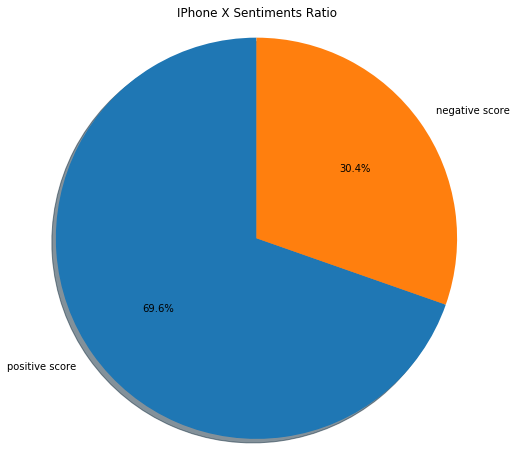

In [26]:
# Create Pie Chart showing ratio of positive to negative aspects

iphonex_positive_count = iphone_x['positive score'].sum()
iphonex_negative_count = ((-1)*iphone_x['negative score'].sum())
iphonex_ratio = [iphonex_positive_count, iphonex_negative_count]
labels = 'positive score', 'negative score'

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))
ax.pie(iphonex_ratio, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title("IPhone X Sentiments Ratio")
plt.show()

# Samsung Galaxy S9

In [27]:
s_9.head(10)

,positive aspects,positive score,negative aspects,negative score
0,phone,17.0,motion,-10.0
1,features,14.0,mo,-7.0
2,photos,10.0,water IP68 resistance,-3.0
3,phones,9.0,battery,-2.5
4,way,8.0,sales,-2.0
5,camera,7.0,shader,-2.0
6,design,7.0,words,-2.0
7,colors,7.0,time,-2.0
8,display,6.0,water resistance,-2.0
9,screen,6.0,%,-2.0


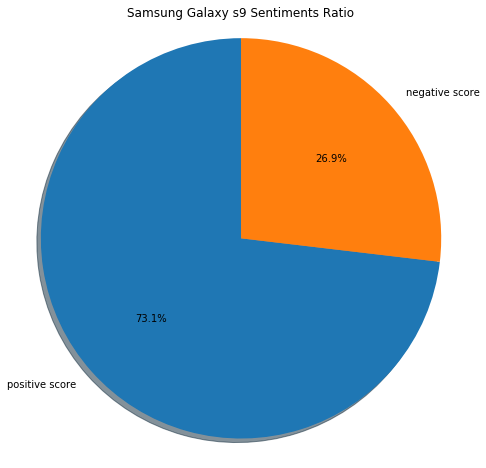

In [28]:
# Create Pie Chart showing ratio of positive to negative aspects

s9_positive_count = s_9['positive score'].sum()
s9_negative_count = ((-1)*s_9['negative score'].sum())
iphonex_ratio = [s9_positive_count, s9_negative_count]
labels = 'positive score', 'negative score'

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))
ax.pie(iphonex_ratio, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title("Samsung Galaxy s9 Sentiments Ratio")
plt.show()

In [29]:
# Create Dataframe of Index comparing sentiments between phones
positive_sentiments_ratio = (iphonex_positive_count/s9_positive_count)
negative_sentiments_ratio = (iphonex_negative_count/s9_negative_count)

comparison_index = pd.DataFrame()
comparison_index['positive sentiments ratio'] = [positive_sentiments_ratio]
comparison_index['negative sentiments ratio'] = [negative_sentiments_ratio]
comparison_index

,positive sentiments ratio,negative sentiments ratio
0,1.019928,1.210412


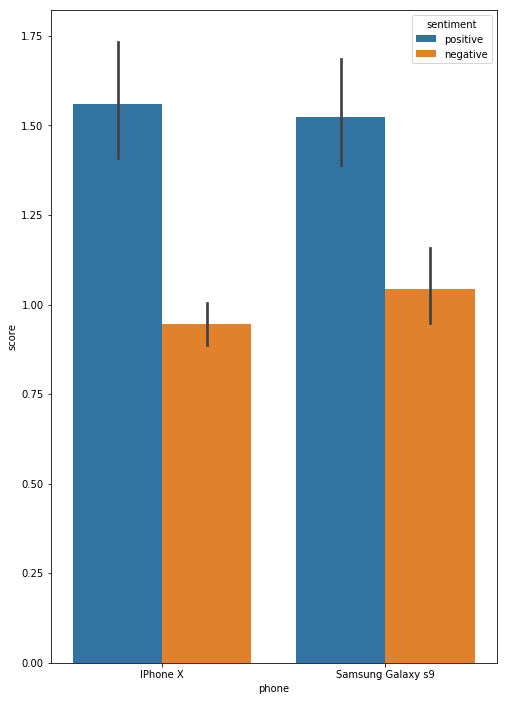

In [30]:
# Barplot comparing the positive and negative sentiments of of both phones
iphonex['phone'] = 'IPhone X'
s9['phone'] = 'Samsung Galaxy s9'

frames = [iphonex, s9]
both_phones = pd.concat(frames)
both_phones['sentiment'] = np.where(both_phones['score']>0, 'positive', 'negative')

both_phones['score'] = both_phones['score'].apply(lambda x: (x**2))
both_phones['score'] = both_phones['score'].apply(lambda x: (math.sqrt(x)))

fig, ax = plt.subplots(figsize=(8,12))
ax = sns.barplot(x="phone", y="score", hue="sentiment", data=both_phones)